In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,roc_auc_score,precision_recall_curve

In [3]:
df = pd.read_csv(r'D:\Internship\Heart_disease_prediction\datasets\cleaned_dataset.csv')

In [4]:
df.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,ST_slope,target
0,40,1,2,140,289.0,0,0,172,0,0.0,1,0
1,49,0,3,160,180.0,0,0,156,0,1.0,2,1
2,37,1,2,130,283.0,0,1,98,0,0.0,1,0
3,48,0,4,138,214.0,0,0,108,1,1.5,2,1
4,54,1,3,150,195.0,0,0,122,0,0.0,1,0


In [5]:
numeric_cols = ['age','resting_bp_s','cholesterol','max_heart_rate','oldpeak']
cat_cols = [i for i in df.columns if i not in numeric_cols and i!='target']

In [6]:
X = df.drop('target',axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [7]:
preprocess = ColumnTransformer(transformers=[
    ("Scaling",StandardScaler(),numeric_cols),
    ("Encoding",OneHotEncoder(handle_unknown='ignore',drop='first'),cat_cols)
])

In [8]:
clfs = {
    'LogisticRegression':LogisticRegression(class_weight='balanced'),
    'RandomForestClassifier':RandomForestClassifier(class_weight='balanced'),
    'XGBClassifier':XGBClassifier()
}


Model: LogisticRegression

Classification Report
               precision    recall  f1-score   support

           0       0.86      0.85      0.86       108
           1       0.84      0.84      0.84        96

    accuracy                           0.85       204
   macro avg       0.85      0.85      0.85       204
weighted avg       0.85      0.85      0.85       204


Confusion Matrix
 [[92 16]
 [15 81]]


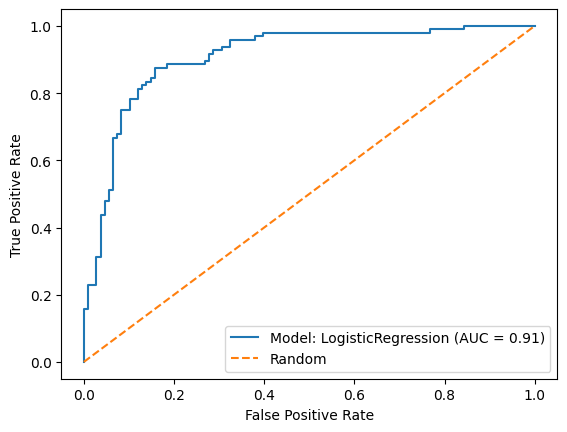


Model: RandomForestClassifier

Classification Report
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       108
           1       0.94      0.94      0.94        96

    accuracy                           0.94       204
   macro avg       0.94      0.94      0.94       204
weighted avg       0.94      0.94      0.94       204


Confusion Matrix
 [[102   6]
 [  6  90]]


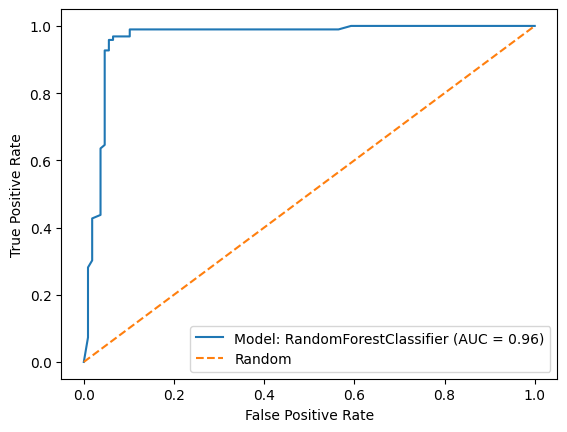


Model: XGBClassifier

Classification Report
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       108
           1       0.93      0.96      0.94        96

    accuracy                           0.95       204
   macro avg       0.95      0.95      0.95       204
weighted avg       0.95      0.95      0.95       204


Confusion Matrix
 [[101   7]
 [  4  92]]


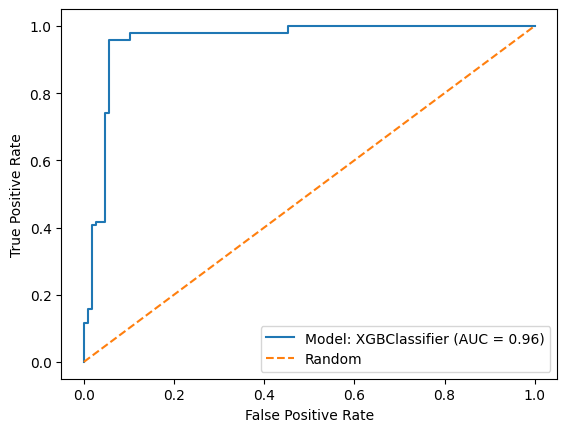

In [9]:
for name,clf in clfs.items():
    model = Pipeline(steps=[
        ("Preprocessing",preprocess),
        ("CLF",clf)
    ])
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    fpr,tpr,thresholds = roc_curve(y_test,y_prob)
    auc = roc_auc_score(y_test,y_prob)
    print(f"\nModel: {name}")
    print("\nClassification Report\n",classification_report(y_test,y_pred))
    print("\nConfusion Matrix\n",confusion_matrix(y_test,y_pred))
    plt.plot(fpr, tpr, label=f"Model: {name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
